# Plan
Get predictions for test data

1. Run same model as in 15d --> for 7d, then 14d, then 21d

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import root_mean_squared_log_error, root_mean_squared_error
import lightgbm as lgb

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
transactions_df = pd.read_csv('data/transactions.csv')
oil_df = pd.read_csv('data/oil.csv')
holidays_df = pd.read_csv('data/holidays_events.csv')
stores_df = pd.read_csv('data/stores.csv')

train_df = train_df.drop(columns='id')
train_df['date'] = pd.to_datetime(train_df['date'])

test_df = test_df.drop(columns='id')
test_df['date'] = pd.to_datetime(test_df['date'])

mask = oil_df.isna().sum(axis=1).astype(bool)
oil_df = oil_df.ffill().bfill()
oil_df['date'] = pd.to_datetime(oil_df['date'])

In [3]:
# delete leap year days
before_len = len(train_df)
train_df = train_df[train_df['date'] != pd.to_datetime('2016-02-29')]
after_len = len(train_df)

print("% Decrease", (before_len - after_len)/before_len)

% Decrease 0.0005938242280285036


In [4]:
def memory_reduce(df):
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and col_type.name != 'category':
            if np.issubdtype(col_type, np.integer):
                df[col] = pd.to_numeric(df[col], downcast='integer')
            elif np.issubdtype(col_type, np.floating):
                df[col] = pd.to_numeric(df[col], downcast='float')

        if col_type == object:
            df[col] = df[col].astype('category')
    
    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage reduced from {start_mem:.2f} MB to {end_mem:.2f} MB "
          f"({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)")
    return df

def prepareModel(df, setting = 1):
    # combined will be the running combined df
    lag_features = df.copy()

    settingMap = \
        {
            1: ['7D', '14D', '21D'],
            2: ['14D', '21D', '28D'],
            3: ['21D', '28D', '35D']
        }
    baseDay = settingMap[setting][0]
    baseSales = f'sales{baseDay}'

    # 1. 14d ago lag
    for lag in settingMap[setting]: # these are the defining lags
        shiftd = train_df.copy()
        shiftd['date'] = shiftd['date'] + pd.Timedelta(lag)
        shiftd = shiftd[['date', 'store_nbr', 'family', 'sales']].rename(columns={'sales': f'sales{lag}'})
        lag_features = pd.merge(lag_features, shiftd, how='inner', on=['date', 'store_nbr', 'family'])

    lag_features.head()

    # 2. rolling (over the past 1w, what is avg)
    rolling_features = lag_features.copy()

    for lag in ['7D', '14D', '28D', '365D']:
        rollingd = lag_features.groupby(['store_nbr', 'family']).rolling(lag, on='date')[baseSales].mean()
        rollingd = rollingd.reset_index()[['date', 'store_nbr', 'family', baseSales]].rename(columns={baseSales: f'rolling{lag}'})
        rolling_features = pd.merge(rolling_features, rollingd, how='inner', on=['date', 'store_nbr', 'family'])

    rolling_features = rolling_features.dropna(axis=0)
    rolling_features.head(10)

    # 3. day of week for the last month
    dow_features = rolling_features.copy()
    dow_features['day_of_week'] = dow_features['date'].dt.day_of_week

    for lag in ['7D', '14D', '28D', '365D']:
        same_dow = dow_features.groupby(['store_nbr', 'family', 'day_of_week']).rolling(lag, on='date')[baseSales].mean()
        same_dow = same_dow.rename(f'dow{lag}')
        dow_features = pd.merge(dow_features, same_dow, on=['store_nbr', 'family', 'date'])

    # 4. ratios of rolling to dow
    ratio = dow_features.copy()
    for lag in ['14D', '28D', '365D']:
        ratio[f'dowratio{lag}'] = ratio[f'rolling{lag}'] / ratio[f'dow{lag}']

    # 6. is holiday
    holiday_features = ratio.copy()

    holidays_df['date'] = pd.to_datetime(holidays_df['date'])
    holiday_features['is_holiday'] = holiday_features['date'].isin(holidays_df['date'])

    shifted_holiday = holiday_features.copy()
    shifted_holiday['date'] = shifted_holiday['date'] + pd.Timedelta('14D')
    shifted_holiday = shifted_holiday[['date', 'is_holiday', 'store_nbr', 'family']].rename(columns={'is_holiday': 'shift_is_holiday'})

    holiday_features = pd.merge(holiday_features, shifted_holiday, on=['date', 'store_nbr', 'family'], how='inner')

    return memory_reduce(holiday_features)

In [5]:
def sampleTest(cleaned):
    dates = cleaned['date']
    X = cleaned.drop(columns=['date', 'sales'])
    y = cleaned['sales']

    X_train, y_train = X[dates < pd.to_datetime('2017-01-01')], y[dates < pd.to_datetime('2017-01-01')]
    X_test, y_test = X[dates >= pd.to_datetime('2017-01-01')], y[dates >= pd.to_datetime('2017-01-01')]

    categorical_features = X_train.select_dtypes(include='category').columns

    model = lgb.LGBMRegressor(
                n_estimators=100,
                num_leaves=31,
                learning_rate = 0.1
            )

    model.fit(X_train,
            np.log1p(y_train),
            categorical_feature=categorical_features)
    
    predictions = model.predict(X_test)
    overall_rmse = root_mean_squared_error(predictions, np.log1p(y_test))

    chunks = 20
    step = len(y_test)//chunks

    results = []
    for start_idx in np.arange(start=0, stop=len(y_test), step=step):
        end_idx = start_idx + step
        rmse = root_mean_squared_error(predictions[start_idx:end_idx], np.log1p(y_test[start_idx:end_idx]))
        results.append(rmse)

    print(overall_rmse)
    print(results)

In [6]:
cleaned = prepareModel(train_df, setting=3)
sampleTest(cleaned)

Memory usage reduced from 430.69 MB to 302.58 MB (29.7% reduction)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3867
[LightGBM] [Info] Number of data points in the train set: 2464506, number of used features: 20
[LightGBM] [Info] Start training from score 2.850039
0.5606239042913205
[1.4198181812571442, 0.4677763821151699, 0.4338969024781401, 0.5484008668825396, 0.4706214297529021, 0.41194350426374016, 0.41454783676190937, 0.5608532923791918, 0.4384803938589472, 0.5210429905512507, 0.5400070472393137, 0.49868149530677464, 0.4892179601577423, 0.4853173386834721, 0.4688315390661289, 0.4529244678837294, 0.43277422024020085, 0.4390215608377516, 0.4529482919214447, 0.4422836882675929, 0.7393793096687954]


In [7]:
def prepareTest(setting=1):
    combined_df = pd.concat([train_df, test_df])
    combined_df = combined_df.fillna(-1)
    clean = prepareModel(combined_df, setting=setting)

    dates = clean['date']
    X = clean.drop(columns=['date', 'sales'])
    y = clean['sales']

    test_start = pd.to_datetime('2017-08-16')
    test_end_map = {
                1: '2017-08-23',
                2: '2017-08-30',
                3: '2017-09-01'
        }
    test_end = pd.to_datetime(test_end_map[setting])

    X_train, y_train = X[dates < test_start], y[dates < test_start]
    X_test, y_test = X[(dates >= test_start) & (dates < test_end)], y[(dates >= test_start) & (dates < test_end)]

    categorical_features = X_train.select_dtypes(include='category').columns

    model = lgb.LGBMRegressor(
                n_estimators=100,
                num_leaves=31,
                learning_rate = 0.1
            )

    model.fit(X_train,
            np.log1p(y_train),
            categorical_feature=categorical_features)
    
    predictions = model.predict(X_test)
    return predictions

In [8]:
overallResults = []
for i in range(1, 4):
    currentRes = prepareTest(i)
    overallResults.append(currentRes)

Memory usage reduced from 437.68 MB to 307.48 MB (29.7% reduction)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3877
[LightGBM] [Info] Number of data points in the train set: 2892186, number of used features: 20
[LightGBM] [Info] Start training from score 2.949370
Memory usage reduced from 437.68 MB to 318.56 MB (27.2% reduction)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3874
[LightGBM] [Info] Number of data points in the train set: 2879712, number of used features: 20
[LightGBM] [Info] Start training from score 2.945952
Memory usage reduced from 434.99 MB to 316.61 MB (

In [9]:
flattened = []

prev_length = 0
for sublist in overallResults:
    flattened.extend(sublist[prev_length:])
    prev_length = len(sublist)

In [10]:
sales = np.expm1(flattened)

ids = pd.read_csv('./data/test.csv')['id']
submission = pd.DataFrame({'id': ids, 'sales': sales})
submission.to_csv('./submission.csv', index=False)

# Modify for trailing 0s

In [ ]:
train_df = pd.read_csv('data/train.csv', parse_dates=['date'])
test_df = pd.read_csv('data/test.csv', parse_dates=['date'])

submission_df = pd.merge(left= test_df, right = submission, on='id')
submission_df.head()

,id,date,store_nbr,family,onpromotion,sales
0,3000888,2017-08-16,1,AUTOMOTIVE,0,3.978243
1,3000889,2017-08-16,1,BABY CARE,0,0.020341
2,3000890,2017-08-16,1,BEAUTY,2,4.231931
3,3000891,2017-08-16,1,BEVERAGES,20,2441.200630
4,3000892,2017-08-16,1,BOOKS,0,0.355369


In [17]:
print("Before, # 0 predictions:", len(submission_df[submission_df['sales'] == 0]))
print("Before, # predictions within 0.01:", np.isclose(submission_df['sales'], 0, atol=0.01).sum())

Before, # 0 predictions: 0
Before, # predictions within 0.01: 72


In [32]:
end_train = train_df['date'].max()
two_week_before = end_train - pd.Timedelta('13D')

last_two = train_df.set_index('date').loc[two_week_before:end_train]
trailing_zero = last_two.groupby(by=['store_nbr', 'family'])['sales'].sum().to_frame('sum_sales').reset_index()

to_zero = trailing_zero.copy()
to_zero['zero'] = to_zero['sum_sales'] == 0
to_zero.drop(columns='sum_sales')
to_zero

,store_nbr,family,sum_sales,zero
0,1,AUTOMOTIVE,66.000000,False
1,1,BABY CARE,0.000000,True
2,1,BEAUTY,55.000000,False
3,1,BEVERAGES,27025.000000,False
4,1,BOOKS,0.000000,True
...,...,...,...,...
1777,54,POULTRY,919.683996,False
1778,54,PREPARED FOODS,1226.000000,False
1779,54,PRODUCE,9306.154000,False
1780,54,SCHOOL AND OFFICE SUPPLIES,0.000000,True


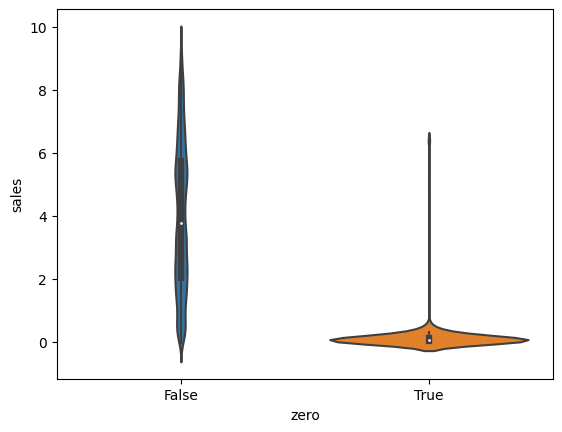

In [38]:
# Visualize trailing 0s vs. not trailing 0s predictions
zero_submission = submission_df.merge(to_zero, on=['store_nbr', 'family'])
sns.violinplot(data=zero_submission, x='zero', y=np.log1p(zero_submission['sales']))

# Zero out sales prediction when trailing 0s
zero_submission['sales'] = np.where(zero_submission['zero'], 0, zero_submission['sales'])
zero_submission[['id', 'sales']].to_csv('./submission.csv', index=False)